# Load Packages and Data

## Packages

In [1]:
import contextily as ctx
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import numpy as np
import pandas as pd
import requests
import xarray as xr
import os

## Links and Variables

In [2]:
# decide date range for data
# start date
sdate = '2018-10-01'
# end date
fdate =  '2022-12-31'

# Flight boundary KML Directory
boundaries = 'Boundary_KMLs/PLAN_1585_v01_all_swaths_Jan22-May7.kml'

## CSO Data

In [3]:
# Load CSO domain JSON
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")

# parameters for boundaries
params = {
  "bbox": "-90 , 75 , -168 , 26 ",
  "startDate": sdate,
  "endDate": fdate ,
  "format": "geojson",
  "limit": 500000,
}

# download data from repository 
csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs='epsg:4326')

# Convert timestamp from string to datetime type
CSO_gdf['timestamp'] = pd.to_datetime(CSO_gdf.timestamp)
CSO_gdf.sort_values('timestamp', inplace=True)

# print a random sample of points
print(f'We pulled : {len(CSO_gdf)} measurements from the CSO database \n' )
CSO_gdf.sample(10)


We pulled : 11266 measurements from the CSO database 



,geometry,id,author,depth,source,timestamp,elevation
2088,POINT (-149.67900 61.09690),KomNj0W/,Joseph Kurtak,175.0,SnowPilot,2022-01-26 21:08:00+00:00,616.721069
8222,POINT (-119.06446 50.36698),OJiaKlnl,Karsten von Hoesslin,179.0,MountainHub,2020-02-01 01:47:34.149000+00:00,1753.569580
2163,POINT (-112.21835 40.39588),G56v2pcS,Jason Habib,63.0,SnowPilot,2022-01-23 21:06:00+00:00,2492.917969
3244,POINT (-111.01266 43.48485),FN8QemIr,Zeno Wicks,68.0,SnowPilot,2021-12-15 20:45:00+00:00,2537.838623
4569,POINT (-116.35006 51.45697),JW2gUGRJ,Derek Tryon,163.0,SnowPilot,2021-03-01 18:14:00+00:00,2368.815674
7154,POINT (-151.65707 59.44456),D2MOmLPD,Erin Mckittrick,32.0,MountainHub,2020-11-22 21:00:00+00:00,527.656372
1414,POINT (-149.18822 60.78969),eSi3v7OZ,Katreen Wikstrom Jones,310.0,MountainHub,2022-02-26 19:59:34.962000+00:00,444.686249
6791,POINT (-121.53983 43.97404),KQefdQcK,Bart Wills,85.0,MountainHub,2020-12-11 23:00:30.288000+00:00,1662.650635
5445,POINT (-114.71608 43.87325),YFJS8m1x,jamie weeks,130.0,SnowPilot,2021-01-30 22:00:00+00:00,2574.132568
760,POINT (-111.42581 45.20712),E191Uf99,Nata de Leeuw,148.0,SnowPilot,2022-03-30 19:10:00+00:00,2570.157227


## Read in the Datasets

In [4]:
# Read in the CSO Data
df = CSO_gdf

# use fiona to load in the kml files from the flight boundaries
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
flight_bound = gpd.read_file(boundaries, driver='KML')

# Clean up the string a bit
flight_bound['Name'] = flight_bound['Name'].str[0:-18]

# Merge the polygons

In [5]:
# Create subset for boundary to play with
FB = flight_bound

# Join the flights (JF) by using dissolve command
JF = FB.dissolve( by = 'Name', as_index = False )

# back to original name
flight_bound = JF 

# print check
print('New plygon boundaries:')
display(flight_bound)

New plygon boundaries:


,Name,geometry,Description
0,alamos,"POLYGON ((-106.54263 35.69443, -106.30516 35.6...",
1,donner,"POLYGON ((-120.68709 39.16362, -120.49122 39.0...",
2,dorado,"POLYGON ((-120.17491 38.61286, -119.93997 38.6...",
3,fraser,"POLYGON ((-105.93258 39.77722, -106.01819 39.7...",
4,grmesa,"POLYGON ((-107.85779 39.09555, -107.80946 39.0...",
5,irnton,"POLYGON ((-107.90969 37.71257, -107.67724 37.6...",
6,lowman,"POLYGON ((-116.20918 43.61008, -116.29838 43.5...",
7,peeler,"POLYGON ((-106.79736 38.81616, -106.75989 38.7...",
8,rockmt,"POLYGON ((-105.54823 40.37152, -105.54790 40.3...",
9,sierra,"POLYGON ((-118.80649 37.05823, -118.79514 36.9...",


## Check the projections and metadata of each dataset

In [6]:
# do the projections match?
TF = flight_bound.crs == df.crs # test if they are equal
print(f'Do the flight and point data have the same projection: {TF} \n')

print('What Projection are they in: ')
print(f'CSO Depth Projection: {df.crs}')
print(f'Snowex Flight Projection: {flight_bound.crs}')

Do the flight and point data have the same projection: True 

What Projection are they in: 
CSO Depth Projection: epsg:4326
Snowex Flight Projection: epsg:4326


## Visualize whole dataset

<Figure size 4000x4000 with 0 Axes>

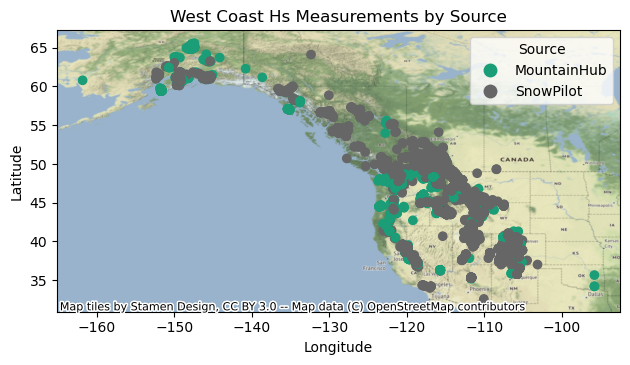

In [7]:
fig = plt.figure(figsize=(40, 40))
ax1 = df.plot(column = 'source',
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend  
    legend_kwds={
        'title': 'Source' # Label the legend
        }, 
    )

# Add the basemap
ctx.add_basemap(ax1, # Add to the current axis
    crs=df.crs, # Assign the same CRS as the Dataframe
    source=ctx.providers.Stamen.TerrainBackground) # Determine what the base map is

# labels and titles
plt.title('West Coast Hs Measurements by Source')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# add the base map
ctx.add_basemap(ax1, crs=df.crs)

# layout and show
plt.tight_layout()
# plt.savefig('All_Submitted_Hs.png', dpi = 300)
plt.show()

# Clean

## Clip to the boundaries

In [8]:
# add a site column to the dataframe
df["Site"] = np.nan

# re-order dataframe
df = df [['Site' , 'timestamp' , 'elevation' , 'depth' , 'geometry' , 'source' , 'author' , 'id']]

# clip to the boundaries
df = gpd.clip(df , flight_bound) # clip the dataframe to the flight boundaries
df # Run a check of number of rows

# Assign a Site to each point
for index, row in df.iterrows(): # for the indices and rows 
    point = row["geometry"] # pull the geometry to test
    for num, ob in flight_bound.iterrows(): # for ever 
        if point.within(ob["geometry"]): 
            # print(ob["Name"]) 
            df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name

##################### save to geojson #####################
df.to_file('CSO_FlightLine_Data.geojson', driver = 'GeoJSON')

# print a quick chekc of final data types
display(f'There are : {len(df)} CSO measurements' )
print(f'\ndata types: \n {df.dtypes} \n')
display(df.sample(15))

C:\Users\Owner\AppData\Local\Temp\ipykernel_27156\3919616018.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name
c:\Users\Owner\anaconda3\envs\GDAL\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'There are : 2031 CSO measurements'


data types: 
 Site                      object
timestamp    datetime64[ns, UTC]
elevation                float64
depth                    float64
geometry                geometry
source                    object
author                    object
id                        object
dtype: object 



,Site,timestamp,elevation,depth,geometry,source,author,id
3378,sierra,2021-12-09 21:30:00+00:00,2711.531738,60.00,POINT (-119.05454 37.64588),SnowPilot,Chris Engelhardt,fLPOyLiL
4427,fraser,2021-03-07 17:30:00+00:00,2929.743896,85.00,POINT (-105.60900 39.94200),SnowPilot,Zach Ryan,+9N3QhQl
6739,irnton,2020-12-14 19:48:00+00:00,3393.268311,67.00,POINT (-107.70500 37.74200),SnowPilot,Austin Finnell,SAkqt/GB
10166,dorado,2019-01-09 21:10:00+00:00,2181.613770,115.00,POINT (-120.11931 38.98504),SnowPilot,Brandon Schwartz,LNJy0VaU
6995,dorado,2020-12-01 19:15:00+00:00,2156.776855,58.00,POINT (-120.14386 39.00344),SnowPilot,Steve Reynaud,3EykbNb9
3488,fraser,2021-12-02 18:30:00+00:00,3780.877197,148.00,POINT (-105.88571 39.77982),SnowPilot,Austin DiVesta,/baiQTVe
4687,lowman,2021-02-25 20:14:16.660000+00:00,1963.880493,487.68,POINT (-116.09055 43.75698),MountainHub,Hans-Peter Marshall,m8lF51Bi
3579,dorado,2021-11-22 19:50:00+00:00,2552.686768,55.00,POINT (-119.98081 38.68753),SnowPilot,Andy Anderson,uvreO1xY
374,lowman,2022-11-16 18:12:00+00:00,2041.804810,65.00,POINT (-115.67700 43.94800),SnowPilot,Jackson Negri,5toSyzD/
2849,fraser,2021-12-29 22:00:00+00:00,2917.966064,70.00,POINT (-106.10288 39.82198),SnowPilot,Austin DiVesta,V5eFm4kP


## Plot it again

<Figure size 70000x30000 with 0 Axes>

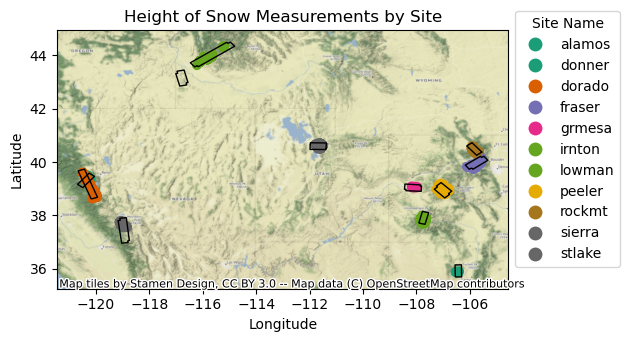

In [9]:
fig = plt.figure(figsize=(700, 300))

# Plot the points
ax1 = df.plot(column = 'Site' , # sorting by the site
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend
    legend_kwds={
        'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Site Name' # Label the legend
        }, 
    )
# Plot the boundaries
flight_bound.plot(ax = ax1 , 
    facecolor = 'none' , # empty polygons 
    edgecolor = 'black') # determine the edge color
plt.title('Height of Snow Measurements by Site')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# add the base map
ctx.add_basemap(ax1, crs=df.crs)
plt.tight_layout()
# plt.savefig('All_Sites_Map.png', dpi = 300)
plt.show()
